<a href="https://colab.research.google.com/github/Mechanics-Mechatronics-and-Robotics/CV-2025/blob/main/Week_12/Hands_on_CLIPSeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zero-Shot Image Segmentation with CLIPSeg

**Implementation** Note:  
This notebook was developed using methodologies suggested by  
the DeepSeek-V3 language model (DeepSeek, 2024).

In [26]:
# Install required libraries
# !pip install -q transformers torch pillow

In [27]:
import requests
import torch
from torch.nn.functional import interpolate

from PIL import Image

from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib import gridspec

from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

import cv2

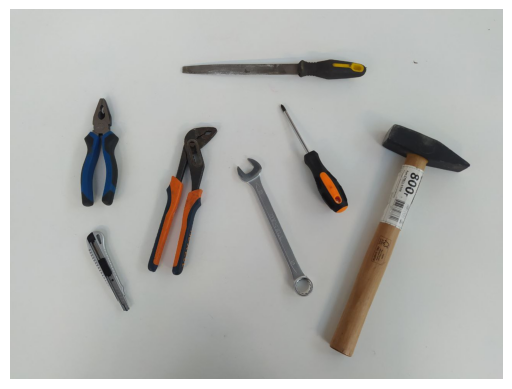

In [28]:
# Use example image or paste your own URL
# url = "https://images.unsplash.com/photo-1573865526739-10659fec78a5"  # Cat image
url = "https://avatars.mds.yandex.net/i?id=16181ba90b059f04bc67cd0af5243a68_l-8169112-images-thumbs&n=13"
image = Image.open("photo/Instruments_2.jpg")

# image = image.resize((224,224))
 
# Display the image
plt.imshow(np.array(image))
plt.axis('off')
plt.show()

In [29]:
import transformers
print(transformers.__version__)

4.51.1


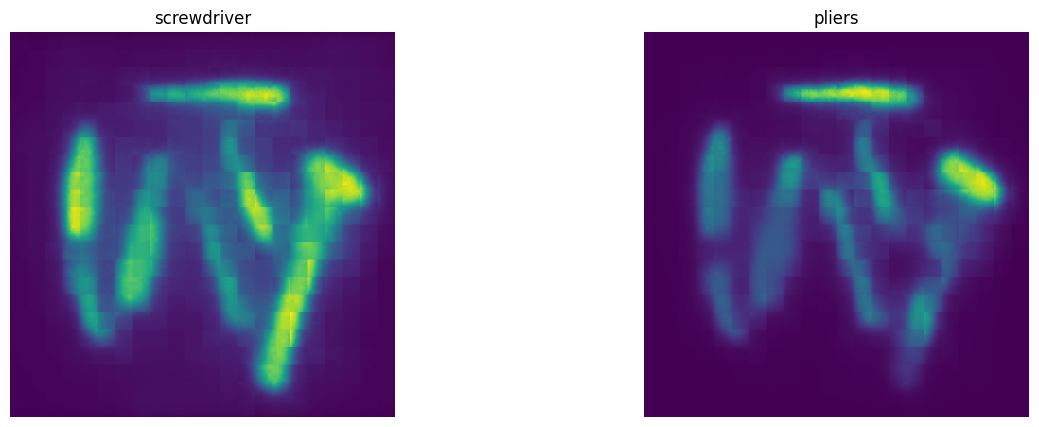

In [ ]:
# Load model
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")


texts = ["screwdriver", "pliers"]
# Process inputs
inputs = processor(text=texts, images=[image]*len(texts), return_tensors="pt", padding=True)

# Predict
with torch.no_grad():
    outputs = model(**inputs)

# Visualize masks
fig, axes = plt.subplots(1, len(texts), figsize=(15,5))
for idx, (text, mask) in enumerate(zip(texts, outputs.logits)):
    axes[idx].imshow(mask.sigmoid().numpy(), cmap='viridis')
    axes[idx].set_title(text)
    axes[idx].axis('off')
plt.show()

In [31]:
for idx, (text, mask) in enumerate(zip(texts, outputs.logits)):
    mask_norm = mask.sigmoid().numpy()
    mean_confidence = mask_norm.mean()
    print(mean_confidence)

0.111644045
0.07093135


C:\Users\Valiu\AppData\Local\Temp\ipykernel_9076\1170958106.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


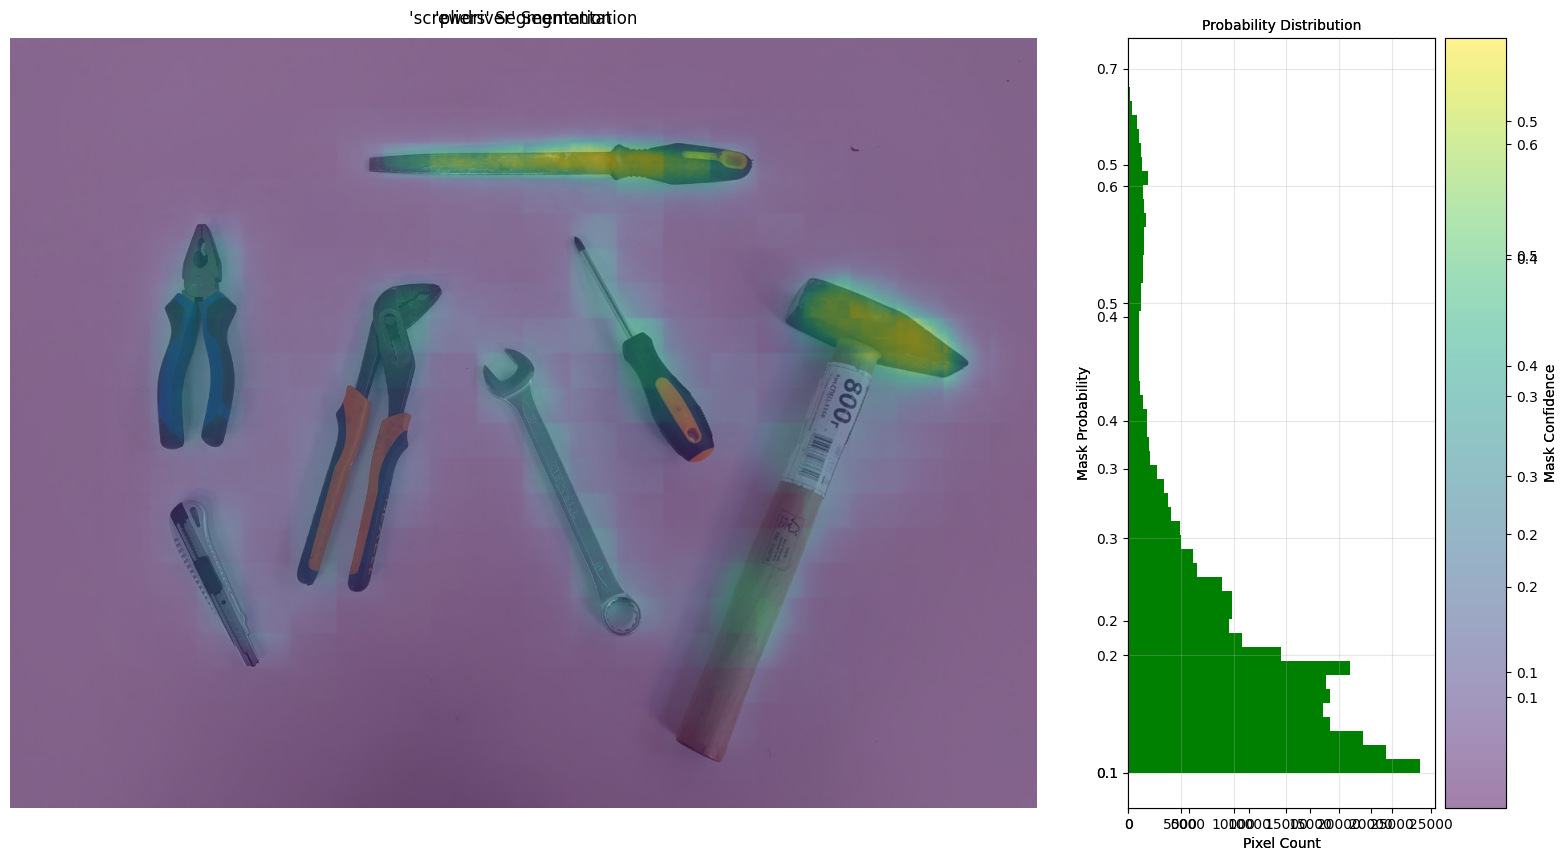

In [32]:
#title Enhanced Segmentation Visualization with Probability Sidebars

# Create figure
fig = plt.figure(figsize=(20, 5 * len(texts)))  # Adjust height based on number of texts

for idx, (text, mask) in enumerate(zip(texts, outputs.logits)):
    # Create grid layout for this segmentation
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1], wspace=0.05)

    # Main image with mask overlay
    ax0 = plt.subplot(gs[0])
    img_array = np.array(image)

    # Resize mask to match image
    mask_resized = interpolate(
        mask.unsqueeze(0).unsqueeze(0),
        size=img_array.shape[:2],
        mode='bilinear'
    ).squeeze().numpy()
    mask_norm = 1 / (1 + np.exp(-mask_resized))

    # Display
    ax0.imshow(img_array)
    overlay = ax0.imshow(mask_norm, cmap='viridis', alpha=0.5)
    ax0.set_title(f"'{text}' Segmentation", fontsize=12, pad=10)
    ax0.axis('off')

    # Add colorbar sidebar
    ax1 = plt.subplot(gs[1])
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="20%", pad=0.1)

    # Create histogram of probabilities
    hist_data = mask_norm.flatten()
    hist_data = hist_data[hist_data > 0.1]  # Filter very low probabilities

    ax1.hist(hist_data, bins=50, orientation='horizontal', color='green')
    ax1.set_xlabel('Pixel Count')
    ax1.set_ylabel('Mask Probability')
    ax1.set_title('Probability Distribution', fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Add colorbar
    plt.colorbar(overlay, cax=cax, label='Mask Confidence')

plt.tight_layout()
plt.show()